In [1]:
#Importing Libraries
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
# Importuojami duomenys
data_path = "E:/jupyter/cats/cats"
BATCH_SIZE = 64
zoom_range = (0.4, 0.5)
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = BATCH_SIZE)

Found 15747 files belonging to 1 classes.


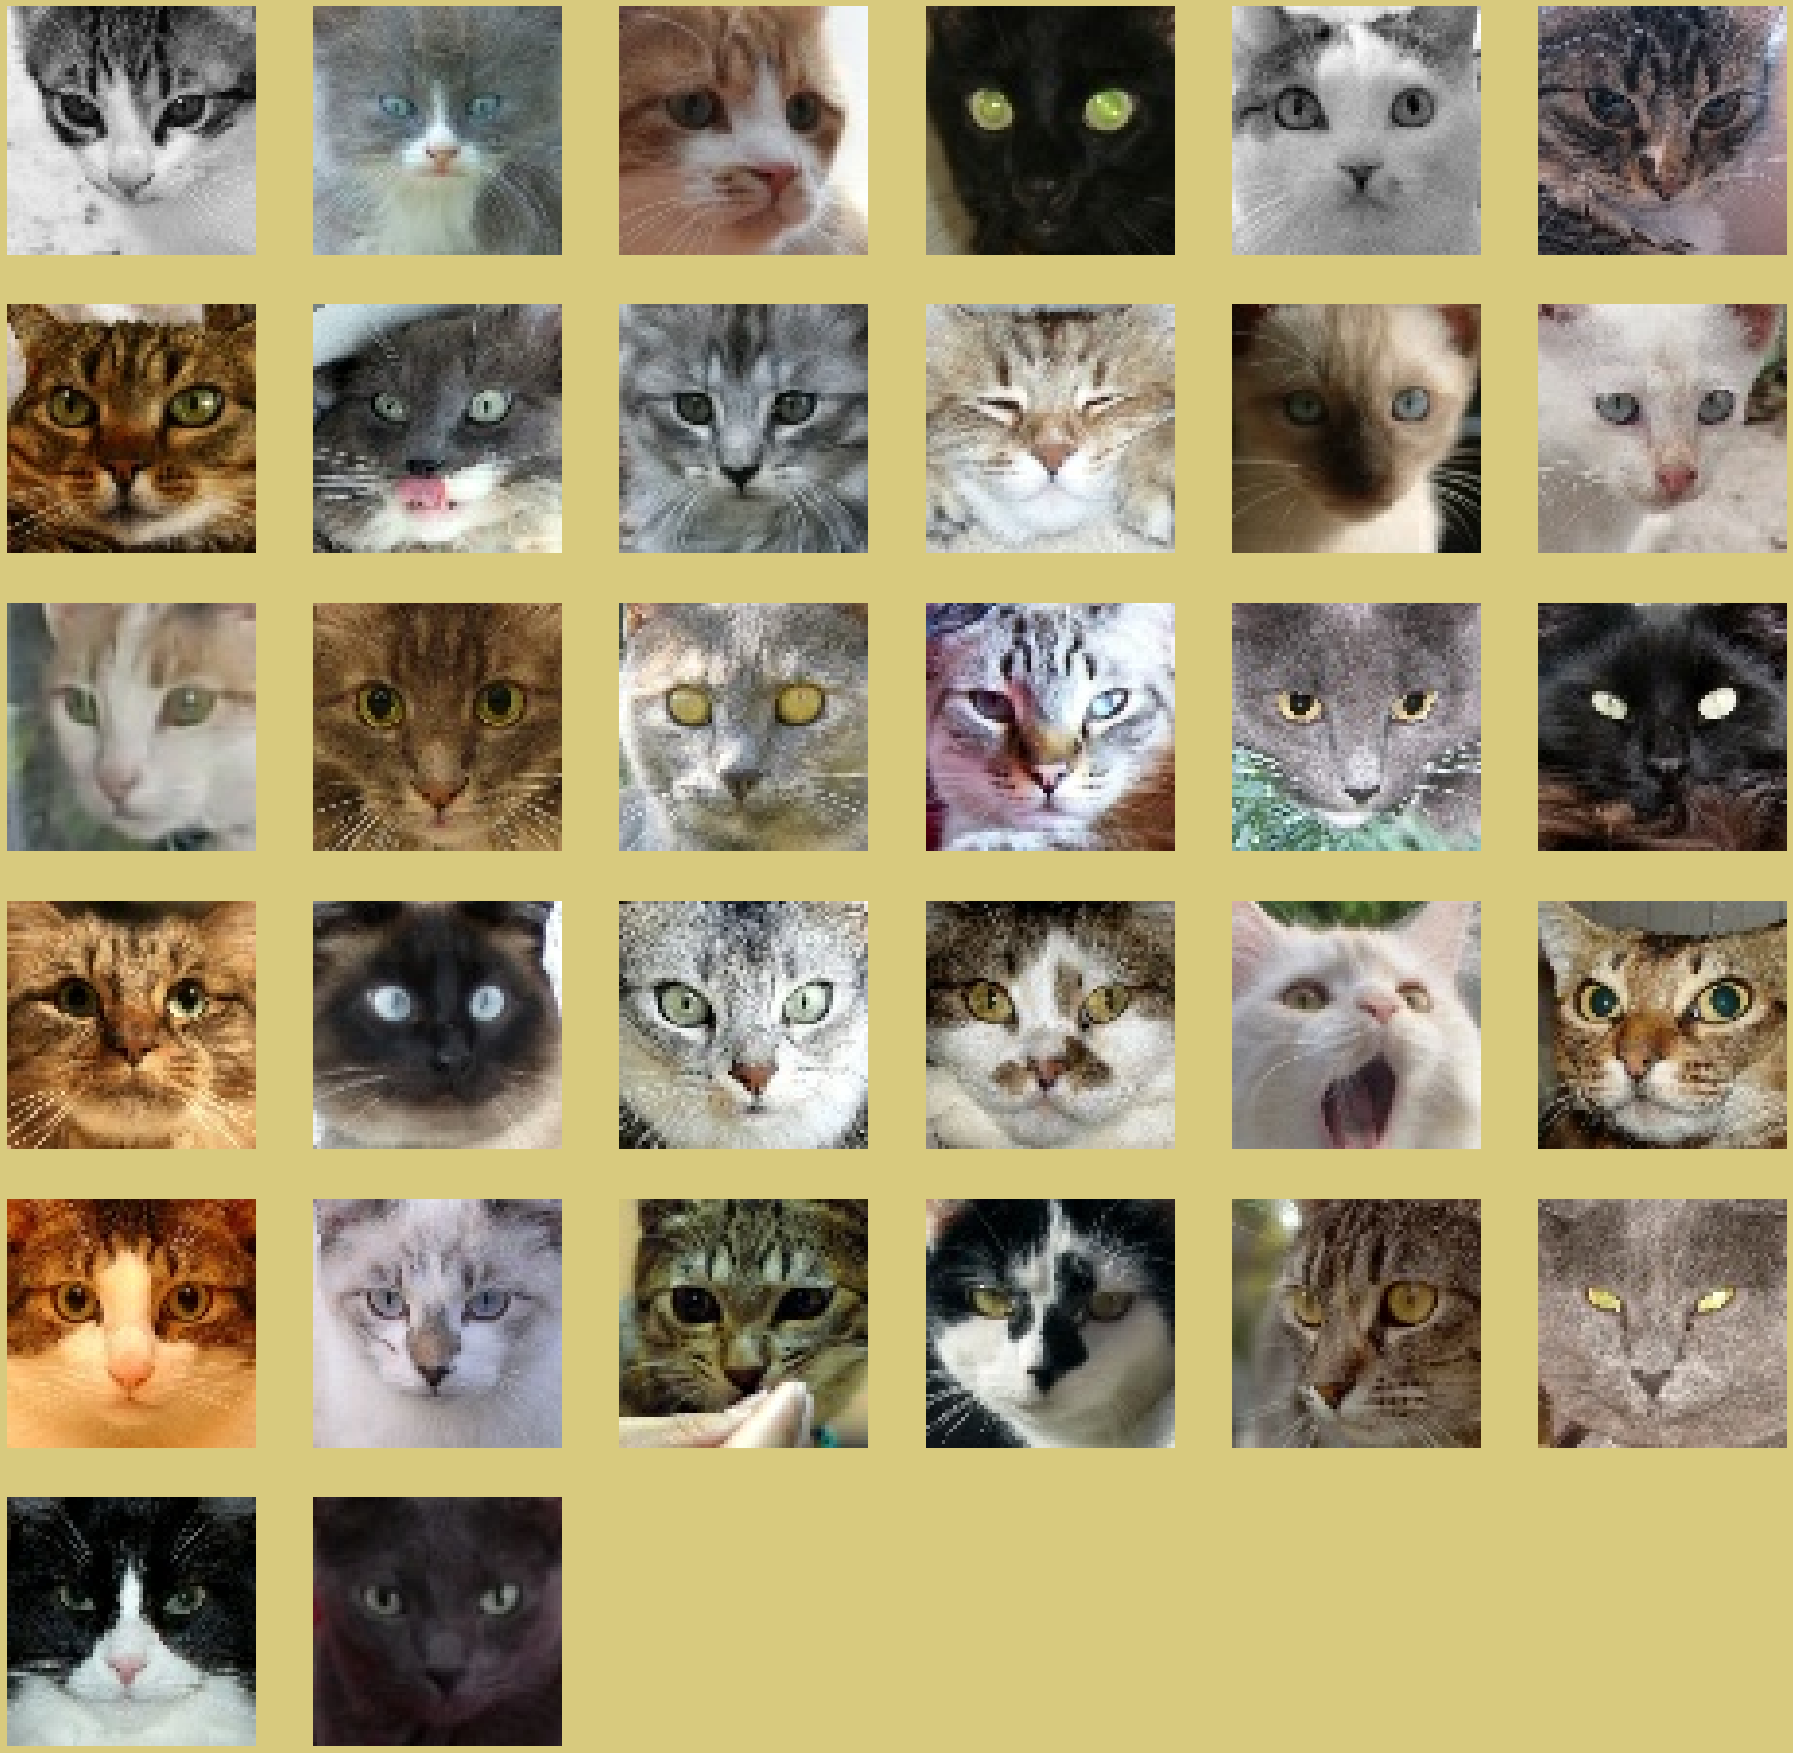

In [3]:
# Duomenu pavyzdys
plt.figure(figsize=(32, 32))
class_names = data.class_names
for images in data.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [3]:
# Normalizuojami duomenys, kad butu [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = data.map(lambda x: (normalization_layer(x)))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.9803922


In [4]:
normalized_ds

<MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [20]:
latent_dim = 100
g_resolution=2
epsilon = 0.00001

# Sukuriamas paveiksliuku generatoriaus modelis
generator = Sequential()
# generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
# generator.add(Reshape((4,4,256)))
# generator.add(UpSampling2D())
# generator.add(Conv2D(256,kernel_size=3,padding="same"))
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(Activation("relu"))
# generator.add(UpSampling2D())
# generator.add(Conv2D(256,kernel_size=3,padding="same"))
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(Activation("relu"))
# generator.add(UpSampling2D())
# generator.add(Conv2D(256,kernel_size=3,padding="same"))#
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(Activation("relu"))
# generator.add(UpSampling2D())
# generator.add(Conv2D(128,kernel_size=3,padding="same"))
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(Activation("relu"))
# generator.add(Conv2D(3,kernel_size=3,padding="same"))
# generator.add(Activation("tanh"))


generator.add(Dense(4*4*512, activation='linear', input_shape=(100,)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Reshape((4, 4, 512)))

generator.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                            kernel_initializer= tf.keras.initializers.TruncatedNormal(stddev=0.02)))
generator.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
generator.add(LeakyReLU(alpha=0.2))

generator.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                            kernel_initializer= tf.keras.initializers.TruncatedNormal(stddev=0.02)))
generator.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
generator.add(LeakyReLU(alpha=0.2))

generator.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                            kernel_initializer= tf.keras.initializers.TruncatedNormal(stddev=0.02)))
generator.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
generator.add(LeakyReLU(alpha=0.2))

generator.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                            kernel_initializer= tf.keras.initializers.TruncatedNormal(stddev=0.02)))
generator.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
generator.add(LeakyReLU(alpha=0.2))

generator.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                            kernel_initializer= tf.keras.initializers.TruncatedNormal(stddev=0.02)))

generator.add(Activation("tanh"))
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 8, 8, 512)        4194816   
 ranspose)                                                       
                                                                 
 batch_normalization_25 (Bat  (None, 8, 8, 512)        2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 8, 8, 512)        

(-0.5, 63.5, 63.5, -0.5)

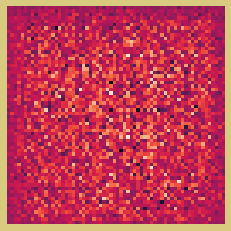

In [22]:
# Sukuriamas neistreniruoto generatoriaus paveiksliukas
seed = tf.random.normal([1, latent_dim])
Generated_Portrait = generator(seed, training=False)
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

In [23]:
# Sukuriamas diskriminatoriaus modelis

discriminator = Sequential()
# discriminator.add(Conv2D(32, 3, 2, input_shape=(64,64,3), padding="same"))
# discriminator.add(LeakyReLU(alpha=0.2))
# discriminator.add(Dropout(0.25))
# discriminator.add(Conv2D(64, 3, 2, padding="same"))
# discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
# discriminator.add(BatchNormalization(momentum=0.8))
# discriminator.add(LeakyReLU(alpha=0.2))
# discriminator.add(Dropout(0.25))
# discriminator.add(Conv2D(128, 3, 2, padding="same"))
# discriminator.add(BatchNormalization(momentum=0.8))
# discriminator.add(LeakyReLU(alpha=0.2))
# discriminator.add(Dropout(0.25))
# discriminator.add(Conv2D(256, 3, 2, padding="same"))
# discriminator.add(BatchNormalization(momentum=0.8))
# discriminator.add(LeakyReLU(alpha=0.2))
# discriminator.add(Dropout(0.25))
# discriminator.add(Conv2D(512, 3, 2, padding="same"))
# discriminator.add(BatchNormalization(momentum=0.8))
# discriminator.add(LeakyReLU(alpha=0.2))
# discriminator.add(Dropout(0.25))
# discriminator.add(Flatten())
# discriminator.add(Dense(1, activation="sigmoid"))

# discriminator.summary()


discriminator.add(Conv2D(128, (3,3), padding='same', input_shape=(64,64,3)))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(128, (3,3), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(BatchNormalization())
discriminator.add(MaxPooling2D(pool_size=(3,3)))
discriminator.add(Dropout(0.2))

discriminator.add(Conv2D(128, (3,3), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(128, (3,3), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(BatchNormalization())
discriminator.add(MaxPooling2D(pool_size=(3,3)))
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_34 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                     

In [24]:
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.49988142]], shape=(1, 1), dtype=float32)


In [25]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")


    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator(seed)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [145]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [146]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [26]:
epochs = 100

discriminator_opt = tf.keras.optimizers.Adam(0.0002,0.5)
generator_opt = tf.keras.optimizers.Adam(0.0002,0.5)

loss_fn = tf.keras.losses.BinaryCrossentropy()

model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

history = model.fit(normalized_ds, epochs=epochs)

Epoch 1/50
247/247 [==============================] - 107s 412ms/step - d_loss: 0.6249 - g_loss: 1.0878
Epoch 2/50
247/247 [==============================] - 97s 392ms/step - d_loss: 0.6245 - g_loss: 1.2071
Epoch 3/50
247/247 [==============================] - 94s 380ms/step - d_loss: 0.6320 - g_loss: 1.0813
Epoch 4/50
247/247 [==============================] - 96s 388ms/step - d_loss: 0.6435 - g_loss: 1.0738
Epoch 5/50
247/247 [==============================] - 95s 385ms/step - d_loss: 0.6424 - g_loss: 1.0644
Epoch 6/50
247/247 [==============================] - 95s 385ms/step - d_loss: 0.6384 - g_loss: 1.0324
Epoch 7/50
247/247 [==============================] - 98s 396ms/step - d_loss: 0.6307 - g_loss: 1.0389
Epoch 8/50
247/247 [==============================] - 98s 397ms/step - d_loss: 0.6298 - g_loss: 1.0584
Epoch 9/50
247/247 [==============================] - 98s 397ms/step - d_loss: 0.6296 - g_loss: 1.0151
Epoch 10/50
247/247 [==============================] - 99s 398ms/step - 

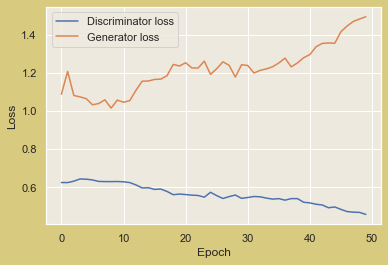

In [27]:
plt.plot(history.history['d_loss'], label="Discriminator loss")
plt.plot(history.history['g_loss'], label="Generator loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()

In [97]:
def Potrait_Generator(num_img):
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255 
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("pav{:02d}.png".format(i)) 
    return 

#Generating images
Images = Potrait_Generator(18)

In [104]:

generator.save('saved_model/generator.h5')
discriminator.save('saved_model/discriminator.h5')
model.save_weights('saved_model/Gan2')